## Reproduce In-situ Sequencing results with Starfish

In Situ Sequencing (ISS) is an image based transcriptomics technique that can spatially resolve hundreds RNA species and their expression levels in-situ. The protocol and data analysis are described in this [publication](https://www.ncbi.nlm.nih.gov/pubmed/23852452). This notebook walks through how to use Starfish to process the raw images from an ISS experiment into a spatially resolved cell by gene expression matrix. We verify that Starfish can accurately reproduce the results from the authors' original [pipeline](https://cellprofiler.org/previous_examples/#sequencing-rna-molecules-in-situ-combining-cellprofiler-with-imagej-plugins)

Please see [documentation](https://spacetx-starfish.readthedocs.io/en/stable/) for detailed descriptions of all the data structures and methods used here.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from starfish import data, FieldOfView
from starfish.types import Features, Axes

/usr/local/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Load Data into Starfish from the Cloud

The primary data from one field of view correspond to 16 images from 4 hybridzation rounds (r) 4 color channels (c) one z plane (z). Each image is 1044 x 1390 (y,x). These data arise from human breast tissue. O(10) transcripts are barcoded for subsequent spatial resolution. Average pixel intensity values for one 'spot' in the image, across all rounds and channels, can be decoded into the nearest barcode, thus resolving each pixel into a particular gene.

In [9]:
use_test_data = os.getenv("USE_TEST_DATA") is not None

# An experiment contains a codebook, primary images, and auxiliary images
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()

pp = pprint.PrettyPrinter(indent=2)
pp.pprint(experiment._src_doc)

# note the structure of the 5D tensor containing the raw imaging data
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

 31%|███▏      | 5/16 [00:00<00:00, 49.37it/s]

{ 'codebook': 'codebook.json',
  'extras': {},
  'images': { 'dots': 'dots.json',
              'nuclei': 'nuclei.json',
              'primary': 'hybridization.json'},
  'version': '5.0.0'}


100%|██████████| 16/16 [00:00<00:00, 50.12it/s]

<starfish.ImageStack (r: 4, c: 4, z: 1, y: 1044, x: 1390)>


## Visualize Codebook

The ISS codebook maps each barcode to a gene.This protocol asserts that genes are encoded with a length 4 quatenary barcode that can be read out from the images. Each round encodes a position in the codeword. The maximum signal in each color channel (columns in the above image) corresponds to a letter in the codeword. The channels, in order, correspond to the letters: 'T', 'G', 'C', 'A'. 

In [10]:
experiment.codebook

<xarray.Codebook (target: 31, c: 4, r: 4)>
array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]],

       [[0, 0, 0, 1],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]]], dtype=uint8)
Coordinates:
  * target   (target) object 'SCUBE2' 'MYBL2' 'ER' 'ST-3' 'BCL2' 'MET' ...
  * c        (c) int64 0 1 2 3
  * r        (r) int64 0 1 2 3

## Visualize raw data

A nice way to page through all this data is to use the display command. We have commented this out for now, because it will not render in Github. Instead, we simply show an image from the first round and color channel.

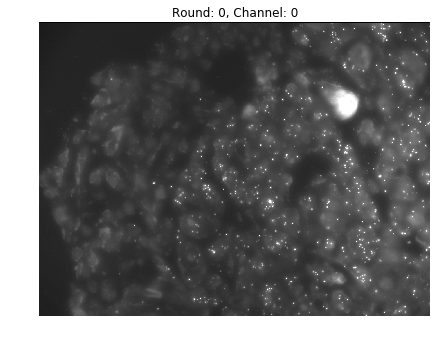

In [13]:
# Display all the data in an interactive pop-up window. Uncomment to have this version work.

# %gui qt5
# display(imgs)

# Display a single plane of data
single_plane = imgs.sel({Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0})
single_plane = single_plane.xarray.squeeze()
plt.figure(figsize=(7,7))
plt.imshow(single_plane, cmap='gray')
plt.title('Round: 0, Channel: 0')
plt.axis('off');

'dots' is a general stain for all possible transcripts. This image should correspond to the maximum projcection of all color channels within a single imaging round. This auxiliary image is useful for registering images from multiple imaging rounds to this reference image. We'll see an example of this further on in the notebook

100%|██████████| 1/1 [00:00<00:00, 93.85it/s]


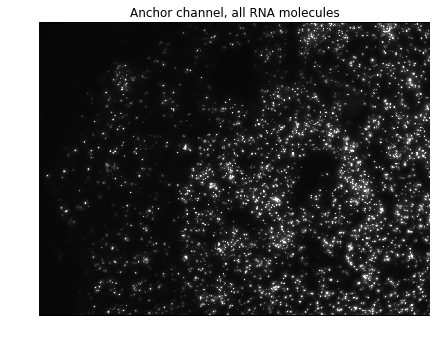

In [15]:
dots = fov.get_image('dots')
dots_single_plane = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE).xarray.squeeze()

plt.figure(figsize=(7,7))
plt.imshow(dots_single_plane, cmap='gray')
plt.title('Anchor channel, all RNA molecules')
plt.axis('off');

Below is a DAPI image, which specifically marks nuclei. This is useful cell segmentation later on in the processing.

100%|██████████| 1/1 [00:00<00:00, 87.09it/s]


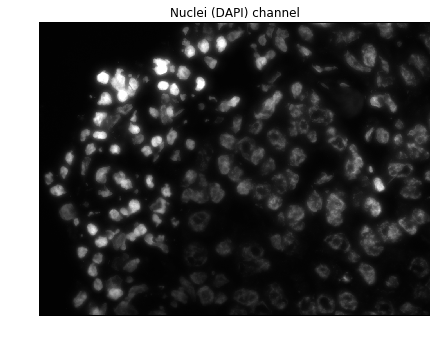

In [17]:
nuclei = fov.get_image('nuclei')

nuclei_single_plane = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE).xarray.squeeze()

plt.figure(figsize=(7,7))
plt.imshow(nuclei_single_plane, cmap='gray')
plt.title('Nuclei (DAPI) channel')
plt.axis('off');

## Filter raw data before decoding into spatially resolved gene expression

A White-Tophat filter can be used to enhance spots while minimizing background autoflourescence. The ```masking_radius``` parameter specifies the expected radius, in pixels, of each spot.

In [18]:
from starfish.image import Filter

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)

16it [00:10,  1.53it/s]


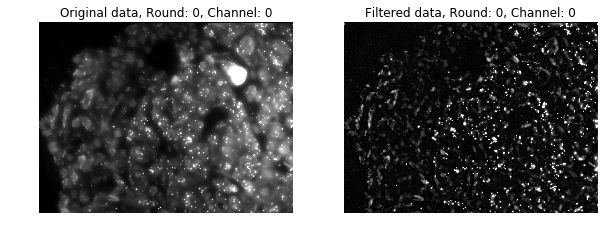

In [19]:
single_plane_filtered = filtered_imgs.sel({Axes.ROUND: 0, Axes.CH: 0, Axes.ZPLANE: 0})
single_plane_filtered = single_plane_filtered.xarray.squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [5, 99])))
plt.axis('off')
plt.title('Original data, Round: 0, Channel: 0')
plt.subplot(122)
plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [5, 99])))
plt.title('Filtered data, Round: 0, Channel: 0')
plt.axis('off');

## Register data

Images may have shifted between imaging rounds. This needs to be corrected for before decoding, since this shift in the images will corrupt the barcodes, thus hindering decoding accuracy. A simple procedure can correct for this shift. For each imaging round, the max projection across color channels should look like the dots stain. Below, we simply shift all images in each round to match the dots stain by learning the shift that maximizes the cross-correlation between the images and the dots stain. 

In [23]:
from starfish.image import ApplyTransform, LearnTransform

learn_translation = LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(imgs.max_proj(Axes.CH, Axes.ZPLANE))
warp = ApplyTransform.Warp()
registered_imgs = warp.run(filtered_imgs, transforms_list=transforms_list, in_place=False, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 152.36it/s]


## Decode the processed data into spatially resolved gene expression profiles

To decode, first we find spots, and record, for reach spot, the average pixel intensities across rounds and channels. This spot detection can be achieved by the ```BlobDetector``` algorithm

In [25]:
from starfish.spots import SpotFinder
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
min_sigma = 1
max_sigma = 10
num_sigma = 30
threshold = 0.01

p = SpotFinder.BlobDetector(
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=num_sigma,
    threshold=threshold,
    measurement_type='mean',
)

# detect triggers some numpy warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # blobs = dots; define the spots in the dots image, but then find them again in the stack.
    intensities = p.run(registered_imgs, blobs_image=dots, blobs_axes=(Axes.ROUND, Axes.ZPLANE))

100%|██████████| 1/1 [00:00<00:00, 86.97it/s]


The resulting "Intensity Table" table is the hypothesized standardized file format for the output of a spot detector, and is the first output file format in the pipeline that is not an image or set of images

In [26]:
intensities

<xarray.IntensityTable (features: 3721, c: 4, r: 4)>
array([[[0.000729, 0.007771, 0.00266 , 0.002893],
        [0.000695, 0.003215, 0.011824, 0.005553],
        [0.006082, 0.003467, 0.003899, 0.004278],
        [0.001056, 0.005346, 0.006525, 0.01406 ]],

       [[0.      , 0.001274, 0.01656 , 0.040028],
        [0.      , 0.002767, 0.050618, 0.060636],
        [0.      , 0.00261 , 0.05035 , 0.034565],
        [0.      , 0.003164, 0.060343, 0.07293 ]],

       ...,

       [[0.00722 , 0.010108, 0.001614, 0.      ],
        [0.017665, 0.072042, 0.006347, 0.      ],
        [0.075244, 0.031259, 0.006514, 0.      ],
        [0.026475, 0.02915 , 0.007797, 0.      ]],

       [[0.011006, 0.022838, 0.003802, 0.01786 ],
        [0.031902, 0.045285, 0.021199, 0.040904],
        [0.027595, 0.042386, 0.018995, 0.04002 ],
        [0.050585, 0.050237, 0.019011, 0.051349]]])
Coordinates:
    z          (features) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    y          (features) int64 1

To decode the resulting intensity table, we simply match intensities to codewards in the codebook. This can be done by, for each round, selecting the color channel with the maximum intensity. This forms a potential quatenary code which serves as the key into a lookup in the codebook as to which gene this code corresponds to. Decoded genes are assigned to the ```target``` field in the decoded intensity table.

In [39]:
decoded = experiment.codebook.decode_per_round_max(intensities)
decoded

<xarray.IntensityTable (features: 3721, c: 4, r: 4)>
array([[[0.000729, 0.007771, 0.00266 , 0.002893],
        [0.000695, 0.003215, 0.011824, 0.005553],
        [0.006082, 0.003467, 0.003899, 0.004278],
        [0.001056, 0.005346, 0.006525, 0.01406 ]],

       [[0.      , 0.001274, 0.01656 , 0.040028],
        [0.      , 0.002767, 0.050618, 0.060636],
        [0.      , 0.00261 , 0.05035 , 0.034565],
        [0.      , 0.003164, 0.060343, 0.07293 ]],

       ...,

       [[0.00722 , 0.010108, 0.001614, 0.      ],
        [0.017665, 0.072042, 0.006347, 0.      ],
        [0.075244, 0.031259, 0.006514, 0.      ],
        [0.026475, 0.02915 , 0.007797, 0.      ]],

       [[0.011006, 0.022838, 0.003802, 0.01786 ],
        [0.031902, 0.045285, 0.021199, 0.040904],
        [0.027595, 0.042386, 0.018995, 0.04002 ],
        [0.050585, 0.050237, 0.019011, 0.051349]]])
Coordinates:
    z                  (features) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    y                  (features)

In [38]:
# Besides house keeping genes, VIM and HER2 should be most highly expessed, which is consistent here.
genes, counts = np.unique(decoded.loc[decoded[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
table = pd.Series(counts, index=genes).sort_values(ascending=False)
table

ACTB     741
GAPDH    271
CTSL2    269
HER2     266
VIM      125
RAC1     109
EPCAM    102
TFRC      88
RPLP0     30
MUC1      27
TP53      24
CCNB1     24
VEGF      17
MKI67     14
GUS       10
CCND1     10
STK15      9
ETV4       7
BAG1       4
CD68       3
ST-3       3
BCL2       3
AIB1       3
MYBL2      2
BIRC5      2
SIX1       2
MYC        1
dtype: int64

## Segment Cells and create Cell by Gene Expression Matrix

After calling spots and decoding their gene information, cells must be segmented to assign genes to cells. This paper used a seeded watershed approach to segment the cells, which we also use here.

100%|██████████| 1/1 [00:00<00:00, 176.71it/s]


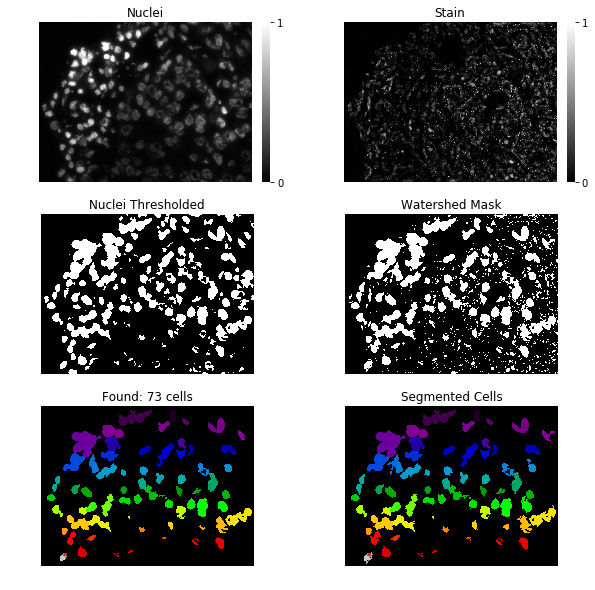

In [32]:
from starfish.image import Segmentation

dapi_thresh = .16  # binary mask for cell (nuclear) locations
stain_thresh = .22  # binary mask for overall cells // binarization of stain
min_dist = 57

registered_mp = registered_imgs.max_proj(Axes.CH, Axes.ZPLANE).xarray.squeeze()
stain = np.mean(registered_mp, axis=0)
stain = stain/stain.max()
nuclei = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)


seg = Segmentation.Watershed(
    nuclei_threshold=dapi_thresh,
    input_threshold=stain_thresh,
    min_distance=min_dist
)
masks = seg.run(registered_imgs, nuclei)
seg.show()

Now that cells have been segmented, we can assign spots to cells in order to create a cell x gene count matrix

In [35]:
from starfish.spots import TargetAssignment
from starfish.expression_matrix.expression_matrix import ExpressionMatrix

al = TargetAssignment.Label()
labeled = al.run(masks, decoded)
cg = labeled.to_expression_matrix()
cg

<xarray.ExpressionMatrix 'expression_matrix' (cells: 67, genes: 28)>
array([[5.890e+02, 3.000e+00, 3.000e+00, ..., 1.000e+01, 7.700e+01, 1.123e+03],
       [3.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00, 6.000e+00],
       [4.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 8.000e+00, 9.000e+00],
       ...,
       [4.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 1.000e+00, 2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00, 1.000e+00]])
Coordinates:
    x        (cells) float64 709.5 860.5 638.0 940.5 1.144e+03 806.5 475.0 ...
    y        (cells) float64 521.5 64.0 63.0 102.5 128.5 134.5 161.5 201.0 ...
    z        (cells) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    xc       (cells) float32 5.1079915e-05 6.195104e-05 4.5932327e-05 ...
    yc       (cells) float32 5e-05 6.136146e-06 6.040268e-06 9.827421e-06 ...
    zc       (cells) float32 5e-05

##  Compare to results from paper

This FOV was selected to make sure that we can visualize the tumor/stroma boundary, below this is described by pseudo-coloring HER2 (tumor) and vimentin (VIM, stroma). This distribution matches the one described in the original paper.

100%|██████████| 1/1 [00:00<00:00, 125.75it/s]


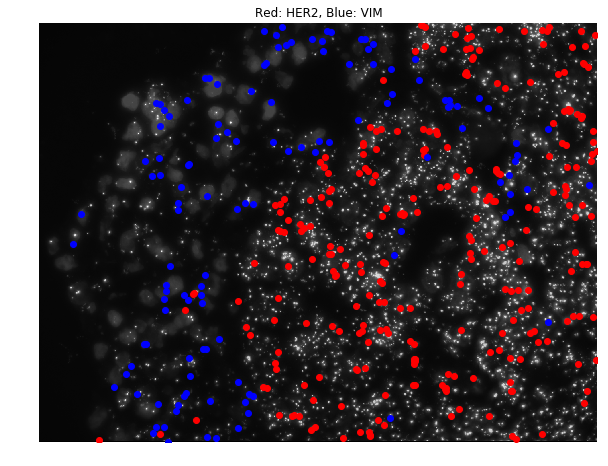

In [36]:
from skimage.color import rgb2gray

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(registered_image.tile_shape + (3,))
nuclei_mp = nuclei.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
nuclei_numpy = nuclei_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_mp = dots.max_proj(Axes.ROUND, Axes.CH, Axes.ZPLANE)
dots_mp_numpy = dots_mp._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_mp_numpy
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)

plt.plot(is_gene1.x, is_gene1.y, 'or')
plt.plot(is_gene2.x, is_gene2.y, 'ob')
plt.title(f'Red: {GENE1}, Blue: {GENE2}');